In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import scorecardpy as sc

In [131]:
df = pd.read_csv('FailureData.csv')

df.head()

,ANNUAL_SALES,IN_DEFAULT,LGD_EFFECTIVE,BALANCE,LEVERAGE_BUYOUT_DEAL,RETURN_ON_ASSETS,DEBT_SRV_CVR_RATIO,CASH_INT_CVR_RATIO,DEBT_DEBT_EQ_RATIO,CASH_FLOW_OP_LIAB,EBITDA_VOLATILITY,NET_WORTH_CPI,NEGATIVE_NPAT_FLAG,MARKET_POSITION,LONG_RUN_AVERAGE_PD
0,201155582,0,"60,32","39616,13",1.0,"-0,034790852","0,7406291301","9,600117217","0,786715851","0,0612390229",0,"6,899188195",1.0,0,"0,0303406937"
1,1522100000,0,"60,32","117561,63",1.0,"0,0422121717",0,"3,295249056","0,2890359795","0,8023872042",0,"8,847155337",0.0,3,"0,0024386606"
2,49765421,0,"60,32","4793327,74",NaN,"0,0608839657",0,"1,934060977","0,8500539338","0,01810406",0,"5,757692996",0.0,0,"0,0385953881"
3,100121596,0,0,0,NaN,"0,193998923",0,"7,611204986",1,"0,2583063995",1,"4,9506995",0.0,5,"0,0276753763"
4,100121596,0,"60,32","33200,12",NaN,"0,193998923",0,"7,611204986",1,"0,2583063995",1,"4,9506995",0.0,5,"0,0276753763"


In [132]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ANNUAL_SALES          394 non-null    object 
 1   IN_DEFAULT            394 non-null    int64  
 2   LGD_EFFECTIVE         394 non-null    object 
 3   BALANCE               394 non-null    object 
 4   LEVERAGE_BUYOUT_DEAL  156 non-null    float64
 5   RETURN_ON_ASSETS      359 non-null    object 
 6   DEBT_SRV_CVR_RATIO    359 non-null    object 
 7   CASH_INT_CVR_RATIO    359 non-null    object 
 8   DEBT_DEBT_EQ_RATIO    359 non-null    object 
 9   CASH_FLOW_OP_LIAB     359 non-null    object 
 10  EBITDA_VOLATILITY     359 non-null    object 
 11  NET_WORTH_CPI         359 non-null    object 
 12  NEGATIVE_NPAT_FLAG    359 non-null    float64
 13  MARKET_POSITION       394 non-null    int64  
 14  LONG_RUN_AVERAGE_PD   394 non-null    object 
dtypes: float64(2), int64(2)

,IN_DEFAULT,LEVERAGE_BUYOUT_DEAL,NEGATIVE_NPAT_FLAG,MARKET_POSITION
count,394.000000,156.0,359.000000,394.000000
mean,0.015228,1.0,0.125348,2.213198
std,0.122616,0.0,0.331575,1.666991
min,0.000000,1.0,0.000000,-3.000000
25%,0.000000,1.0,0.000000,1.000000
50%,0.000000,1.0,0.000000,2.000000
75%,0.000000,1.0,0.000000,3.000000
max,1.000000,1.0,1.000000,5.000000


In [133]:
# There are not much of missed values, so I will just delete whole rows with missing values for this dataset
df = df.dropna()

# Only have values 1 or 0 as there semantic sence is true or false
df['IN_DEFAULT'] = df['IN_DEFAULT'].astype(bool)
df['NEGATIVE_NPAT_FLAG'] = df['NEGATIVE_NPAT_FLAG'].astype(bool) 

# The column max and min value is the same, no actual impact from this column
df.drop('LEVERAGE_BUYOUT_DEAL', axis=1, inplace=True)


In [134]:
# From checking unique values, I found out that all of this columns have commas instead of dots, thats why there were objet types instead of float
# There also were Cyrillic 'E' instead Latin one

columns_to_convert = [
    'ANNUAL_SALES', 'LGD_EFFECTIVE', 'BALANCE', 'RETURN_ON_ASSETS',
    'DEBT_SRV_CVR_RATIO', 'CASH_INT_CVR_RATIO', 'DEBT_DEBT_EQ_RATIO',
    'CASH_FLOW_OP_LIAB', 'EBITDA_VOLATILITY', 'NET_WORTH_CPI',
    'LONG_RUN_AVERAGE_PD'
]

# Function to clean and convert columns
def clean_and_convert(column):
    return (column
            .str.replace('Е', 'E', regex=False)  # Replace Cyrillic 'Е' with Latin 'E'
            .str.replace(',', '.', regex=False)  # Replace commas with dots
            .astype(float))


for column in columns_to_convert:
    df[column] = clean_and_convert(df[column])

df.dtypes

ANNUAL_SALES           float64
IN_DEFAULT                bool
LGD_EFFECTIVE          float64
BALANCE                float64
RETURN_ON_ASSETS       float64
DEBT_SRV_CVR_RATIO     float64
CASH_INT_CVR_RATIO     float64
DEBT_DEBT_EQ_RATIO     float64
CASH_FLOW_OP_LIAB      float64
EBITDA_VOLATILITY      float64
NET_WORTH_CPI          float64
NEGATIVE_NPAT_FLAG        bool
MARKET_POSITION          int64
LONG_RUN_AVERAGE_PD    float64
dtype: object

In [135]:
min_values = df.min(numeric_only=True)
max_values = df.max(numeric_only=True)

min_max_df = pd.DataFrame({'Min': min_values, 'Max': max_values})
min_max_df


,Min,Max
ANNUAL_SALES,110200.0,78200000000.0
IN_DEFAULT,False,False
LGD_EFFECTIVE,0.0,60.32
BALANCE,0.0,19355637.48
RETURN_ON_ASSETS,-0.198377,0.26728
DEBT_SRV_CVR_RATIO,-478.929429,49.760136
CASH_INT_CVR_RATIO,-6.608555,17935898.0
DEBT_DEBT_EQ_RATIO,0.0,1.0
CASH_FLOW_OP_LIAB,-0.126911,0.802387
EBITDA_VOLATILITY,-1.0,2.0


array([[<Axes: title={'center': 'ANNUAL_SALES'}>,
        <Axes: title={'center': 'LGD_EFFECTIVE'}>,
        <Axes: title={'center': 'BALANCE'}>],
       [<Axes: title={'center': 'RETURN_ON_ASSETS'}>,
        <Axes: title={'center': 'DEBT_SRV_CVR_RATIO'}>,
        <Axes: title={'center': 'CASH_INT_CVR_RATIO'}>],
       [<Axes: title={'center': 'DEBT_DEBT_EQ_RATIO'}>,
        <Axes: title={'center': 'CASH_FLOW_OP_LIAB'}>,
        <Axes: title={'center': 'EBITDA_VOLATILITY'}>],
       [<Axes: title={'center': 'NET_WORTH_CPI'}>,
        <Axes: title={'center': 'MARKET_POSITION'}>,
        <Axes: title={'center': 'LONG_RUN_AVERAGE_PD'}>]], dtype=object)

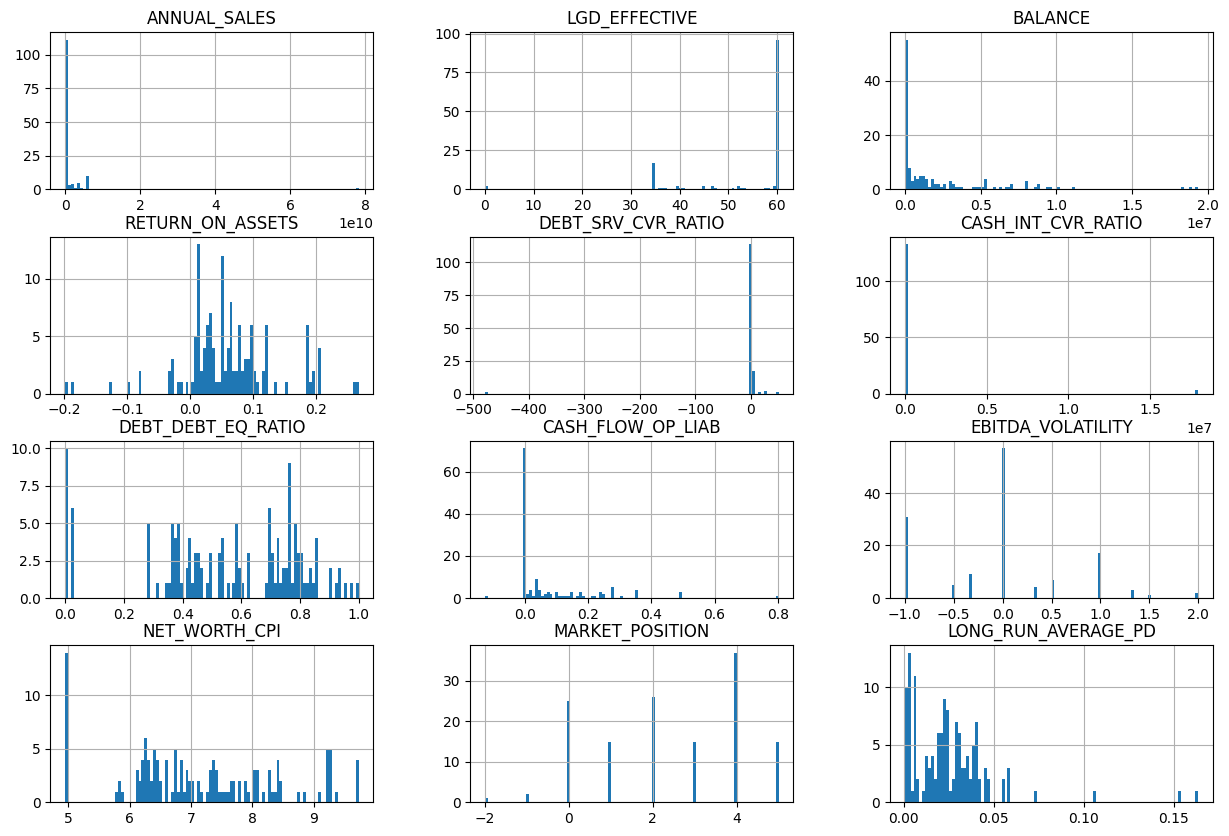

In [136]:
df.hist(figsize=(15,10), bins=100)

In [137]:
# Define continuous columns to bin, excluding the target 'LONG_RUN_AVERAGE_PD'
continuous_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
target = 'LONG_RUN_AVERAGE_PD'
if target in continuous_columns:
    continuous_columns.remove(target)

def dynamic_binning(series, labels):
    # Perform initial qcut with duplicates='drop' to get actual bins
    bins = pd.qcut(series, q=len(labels), duplicates='drop')
    
    # Get the unique bin edges
    unique_bins = bins.cat.categories
    
    # Adjust the labels to match the actual number of unique bins
    adjusted_labels = labels[:len(unique_bins)]
    if len(adjusted_labels) < len(labels):
        # If fewer bins are created, reapply qcut with adjusted labels
        bins = pd.qcut(series, q=len(adjusted_labels), labels=adjusted_labels, duplicates='drop')
    else:
        # Apply labels if no mismatch occurs
        bins = pd.qcut(series, q=len(labels), labels=labels, duplicates='drop')
    
    return bins

# Apply custom binning based on descriptions
df['ANNUAL_SALES_binned'] = dynamic_binning(df['ANNUAL_SALES'], ['Low Sales', 'Medium Sales', 'High Sales'])
df['LGD_EFFECTIVE_binned'] = dynamic_binning(df['LGD_EFFECTIVE'], ['Low Loss', 'Moderate Loss', 'High Loss'])
df['BALANCE_binned'] = dynamic_binning(df['BALANCE'], ['Low Balance', 'Moderate Balance', 'High Balance'])
df['RETURN_ON_ASSETS_binned'] = dynamic_binning(df['RETURN_ON_ASSETS'], ['Low Profitability', 'Moderate Profitability', 'High Profitability'])
df['DEBT_SRV_CVR_RATIO_binned'] = dynamic_binning(df['DEBT_SRV_CVR_RATIO'], ['Low Coverage', 'Moderate Coverage', 'High Coverage'])
df['CASH_INT_CVR_RATIO_binned'] = dynamic_binning(df['CASH_INT_CVR_RATIO'], ['Low Interest Coverage', 'Moderate Interest Coverage', 'High Interest Coverage'])
df['DEBT_DEBT_EQ_RATIO_binned'] = dynamic_binning(df['DEBT_DEBT_EQ_RATIO'], ['Low Leverage', 'Moderate Leverage', 'High Leverage'])
df['CASH_FLOW_OP_LIAB_binned'] = dynamic_binning(df['CASH_FLOW_OP_LIAB'], ['Low Cash Flow', 'Moderate Cash Flow', 'High Cash Flow'])
df['EBITDA_VOLATILITY_binned'] = dynamic_binning(df['EBITDA_VOLATILITY'], ['Low Volatility', 'Moderate Volatility', 'High Volatility'])
df['NET_WORTH_CPI_binned'] = dynamic_binning(df['NET_WORTH_CPI'], ['Low Net Worth', 'Moderate Net Worth', 'High Net Worth'])

# Custom binning for MARKET_POSITION based on the rating scale
df['MARKET_POSITION_binned'] = pd.cut(df['MARKET_POSITION'],
                                      bins=[-float('inf'), -3, -1, 1, 3, float('inf')],
                                      labels=['Very Weak', 'Weak', 'Moderate', 'Strong', 'Very Strong'])

# Binning LONG_RUN_AVERAGE_PD (Target) for interpretability, if needed
df['LONG_RUN_AVERAGE_PD_binned'] = dynamic_binning(df['LONG_RUN_AVERAGE_PD'], ['Low Probability', 'Moderate Probability', 'High Probability'])

# Save the binned dataset excluding original continuous columns
df_binned = df[[col + '_binned' for col in continuous_columns] + ['IN_DEFAULT', 'LONG_RUN_AVERAGE_PD_binned']]


In [ ]:
# Finally, splitting data into train and test
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_binned, test_size=0.1, random_state=42)

train_data.to_csv('failure_data_train.csv', index=False)
test_data.to_csv('failure_data_test.csv', index=False)